# TC 5 project - Part 2 

## Done by : Wafa Bouzouita & Dhiaeddine youssfi


### Invertion of the direct model of SR by estimating the translations for various high-resolution factors.

In [1]:
##Caling the necessary libraries
from nt_toolbox.general import *
from nt_toolbox.signal import *

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy
from numpy import linalg as LA

def ShowImg(img):
    fig = plt.figure()
    plt.gray()  
    plt.imshow(img)
    plt.show() 

### Image lecture

Image dimension : 512 rows 512 columns


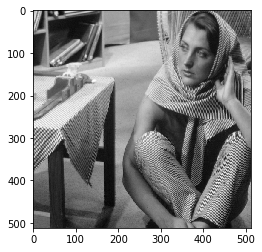

In [2]:
#Lecture of the image in gray scale and conversion in float64
img=np.float64(cv2.imread('barbara.png',0))/255.
shape = img.shape
print("Image dimension :",shape[0],"rows",shape[0],"columns")
plt.imshow(img,cmap = 'gray')

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


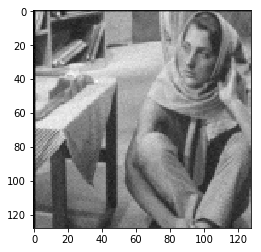

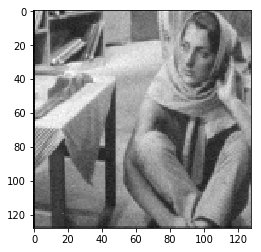

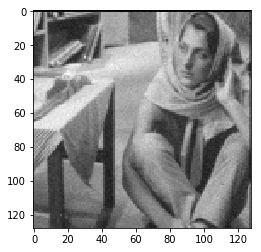

In [3]:
im_names = ["LR_1.png","LR_2.png","LR_3.png"]
im_LR = []
index=0
for im in im_names:
    im_LR.append(scipy.misc.imread(im))
    ShowImg(im_LR[index])
    index +=1

### Translation estimation

In [4]:
# Translation Estimation
def x_trans_slice(img_slice, x_vox_trans, direction):
    """ Return copy of `img_slice` translated by `x_vox_trans` voxels

    Parameters
    ----------
    img_slice : array shape (M, N)
        2D image to transform with translation `x_vox_trans`
    x_vox_trans : int
        Number of pixels (voxels) to translate `img_slice`; can be
        positive or negative.

    Returns
    -------
    img_slice_transformed : array shape (M, N)
        2D image translated by `x_vox_trans` pixels (voxels).
    """
    # Make a 0-filled array of same shape as `img_slice`
    trans_slice = np.zeros(img_slice.shape)
    # Use slicing to select voxels out of the image and move them
    # up or down on the first (x) axis
    if direction == "vertical":
        if x_vox_trans < 0:
            trans_slice[:x_vox_trans, :] = img_slice[-x_vox_trans:, :]
        elif x_vox_trans == 0:
            trans_slice[:, :] = img_slice
        else:
            trans_slice[x_vox_trans:, :] = img_slice[:-x_vox_trans, :]
        return trans_slice
    elif direction == "horizontal":
        if x_vox_trans < 0:
            trans_slice[:, :x_vox_trans] = img_slice[:, -x_vox_trans:]
        elif x_vox_trans == 0:
            trans_slice[:, :] = img_slice
        else:
            trans_slice[:, x_vox_trans:] = img_slice[:, :-x_vox_trans]
    else:
        print("there is not translation in this direction")
    return trans_slice

In [5]:
def mean_abs_mismatch(slice0, slice1):
    """ Mean absoute difference between images
    """
    a=np.ma.masked_invalid(slice0)
    b=np.ma.masked_invalid(slice1)
    msk = (~a.mask & ~b.mask)
    return (LA.norm(np.corrcoef(a[msk],b[msk])))

In [6]:
# we want to estimate the original list of translation trans_dist = [(0, 4), (-4, 0), (4, 0), (0, -3)]
translations = range(-5, 5)  # Candidate values for t
ref_img = scipy.misc.imresize(img,im_LR[0].shape[0]/img.shape[0])
nbr_img = len(im_LR) # number of image
trans_dist_estimated = [[] for i in range(nbr_img)]
index = 0
for tr_im in im_LR:
    for direction in ["vertical", "horizontal"]:
        mismatches = []
        for t in translations:
            # Make the translated image Y_t
            unshifted = x_trans_slice(ref_img, t, direction)
            # Calculate the mismatch
            mismatch = mean_abs_mismatch(unshifted, tr_im)
            # Store it for later
            mismatches.append(mismatch)
        # return the translation distance that maximaze the correlationbetween img_conv and img_trans[index]
        trans_dist_estimated[index].append(translations[np.argmax(mismatches)]) 
    index+=1
# showing the dx,dy translation distance that we estimated, it corresponds perfectly to the original translation that we had/
#perfomed in the direct problem
trans_estimated =[]
for i in range(nbr_img):
    trans_estimated.append(tuple(trans_dist_estimated[i]))
print(trans_estimated)

[(1, 1), (0, 1), (1, 0)]


C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### MASK construction

the percentage of correct pixel is : 18.75 %


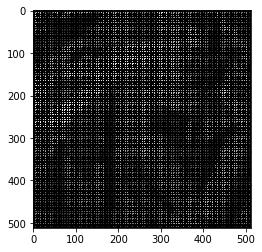

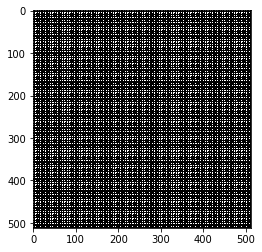

In [7]:
# Generation of low resolution images from original high resolution image, by convolution, translation and down sampling
downs_fac = 4#img.shape[0]//im_LR[0].shape[0] # scaling factor

shape = [im_LR[0].shape[0]*downs_fac,im_LR[0].shape[1]*downs_fac]
M = np.zeros(shape=shape) # Binary mask
img_M = np.zeros(shape=shape) # Low resolution images combination
# Construction of the mask and the masked image with the same size of the original image
i = 0
for x,y in trans_estimated:
    row = np.arange(x,shape[0],downs_fac) if x>=0 else np.arange(0,shape[0]-x,downs_fac)
    col = np.arange(y,shape[1],downs_fac) if y>=0 else np.arange(0,shape[0]-y,downs_fac)
    j = (shape[0]-abs(x)+downs_fac-1) //downs_fac
    k = (shape[1]-abs(y)+downs_fac-1) //downs_fac
    for r in range(j):
        for c in range(k):
            img_M[row[r], col[c]] += im_LR[i][r,c]
            M[row[r], col[c]] = 1
    i += 1

# calculate the percentage of correct pixel 
mean_correct_pixel =  np.sum(M)/(shape[0]*shape[1])
print("the percentage of correct pixel is :", mean_correct_pixel *100,"%")
ShowImg(img_M)
ShowImg(M)

### Inpainting with method 2 : TV inpainting

iteration =  0 , epsilon =  10.0


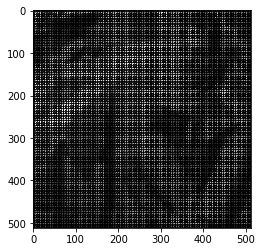

iteration =  100 , epsilon =  10.0


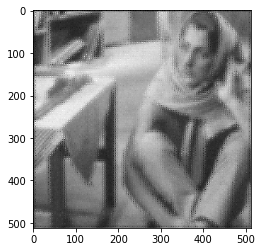

iteration =  200 , epsilon =  10.0


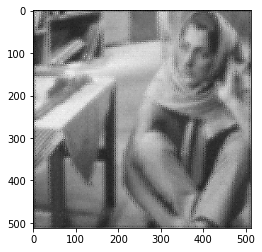

In [8]:
#Inpainting with TV-2 Regularization
# Projection operator 
Pi = lambda f: (1-Omega)*f + (Omega)*y
# Normalization operator 
Amplitude = lambda u,epsilon : np.sqrt(np.sum(u*u,axis=2)+epsilon**2)
Neps = lambda u,epsilon : np.divide(u,(np.tile(Amplitude(u,epsilon), [2, 1, 1])).reshape(shape[0],shape[1],2))
# Gradient of J (smoothed TV norm)
G = lambda f : -div(Neps(grad(f),epsilon))

#Parameters 
#Regularization parameter
epsilon = 10.
#Step size
tau = .9*epsilon/4

#Algorithm
Omega = M #mask
y = img_M
niter = 201
J = []
fTV = y
for i in range(niter):
    J.append(np.sum(np.sum(Amplitude(grad(fTV),epsilon))))
    fTV = Pi( fTV - tau*G(fTV) )
    if i%100==0: 
        print("iteration = ",i,", epsilon = ", epsilon)
        ShowImg(fTV)
    

SNR=-48.58135114764664


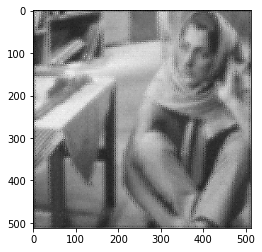

SNR=-10.561187429152723


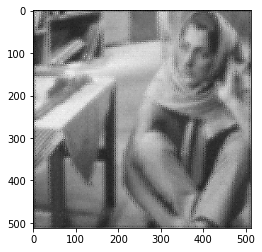

SNR=-1.775094944712716


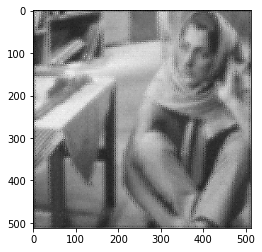

SNR=5.642002911416962


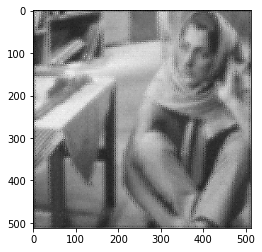

SNR=12.808262019923077


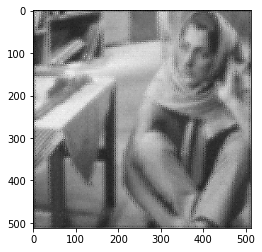

SNR=13.186785860678953


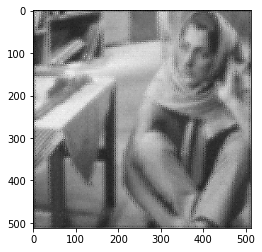

SNR=10.058548968898183


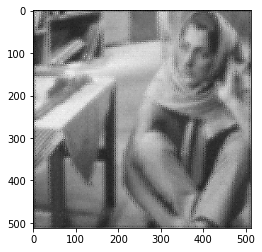

SNR=7.9271652115415385


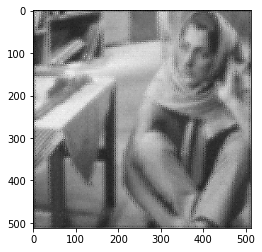

SNR=6.526988184405855


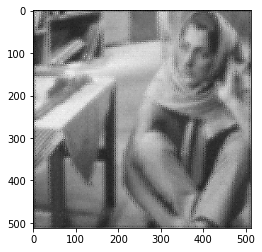

SNR=5.54794456856381


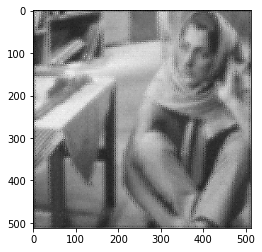

In [9]:
# Choice of the best regularization parameter
#parameters that model the impulse reponse
N= shape[0]
b=np.ones((1,1)) #kernel

# fft
f=fTV
F=np.fft.fft2(b,[N,N])
F[np.abs(F)<1]=0.5
hF=np.ones((N,N))/F
yF = np.fft.fft2(f)

Lambdas = list(np.linspace(2*1e-3, 550., 10)) #regularization parameters
err = []

for Lambda in Lambdas:
    fL2 = np.real( np.fft.ifft2( yF * hF / ( np.abs(hF)**2 + Lambda) ) )
    err.append(snr(img,fL2))
    print('SNR=' + str(snr(img,fL2)))
    ShowImg(fL2)
    

Text(0,0.5,'SNR')

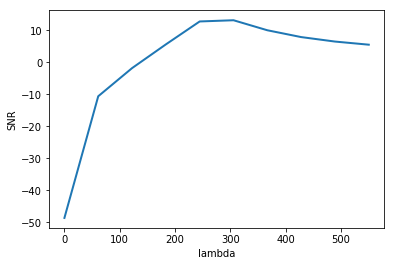

In [11]:
# For the original up scaling to compare the reconstructed image to the original image
plt.plot(Lambdas,err,linewidth=2)
plt.xlabel("lambda")
plt.ylabel("SNR")

In [12]:
# the best regularization parameter is given by
reg_par = Lambdas[np.argmax(err)]
print("the best regularization parameter is of value :",reg_par, "it gives a SNR = ",  err[np.argmax(err)])

the best regularization parameter is of value : 305.5564444444445 it gives a SNR =  13.186785860678953
